In [60]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings("ignore")

In [61]:
# Load and print first 5 rows
df = pd.read_csv('/content/netflix_18-22.csv', encoding='unicode_escape')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [62]:
# Shape of the dataset
df.shape

(1009, 7)

In [63]:
# Statistical Information
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1.009000e+03
mean,419.059673,425.320703,412.374044,419.000733,419.000733,7.570685e+06
std,108.537532,109.262960,107.555867,108.289999,108.289999,5.465535e+06
min,233.919998,250.649994,231.229996,233.880005,233.880005,1.144000e+06
25%,331.489990,336.299988,326.000000,331.619995,331.619995,4.091900e+06
50%,377.769989,383.010010,370.880005,378.670013,378.670013,5.934500e+06
75%,509.130005,515.630005,502.529999,509.079987,509.079987,9.322400e+06
max,692.349976,700.989990,686.090027,691.690002,691.690002,5.890430e+07


In [64]:
# Dataset Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1009 non-null   object 
 1   Open       1009 non-null   float64
 2   High       1009 non-null   float64
 3   Low        1009 non-null   float64
 4   Close      1009 non-null   float64
 5   Adj Close  1009 non-null   float64
 6   Volume     1009 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.3+ KB


In [65]:
# Check for null values
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [66]:
# Preprocess the data

df["Date"] = pd.to_datetime(df["Date"])
df["Open"] = pd.to_numeric(df["Open"], errors='coerce')

df = df.dropna()
data = df['Open'].values.reshape(-1, 1)

scaler = MinMaxScaler()
data = scaler.fit_transform(data)

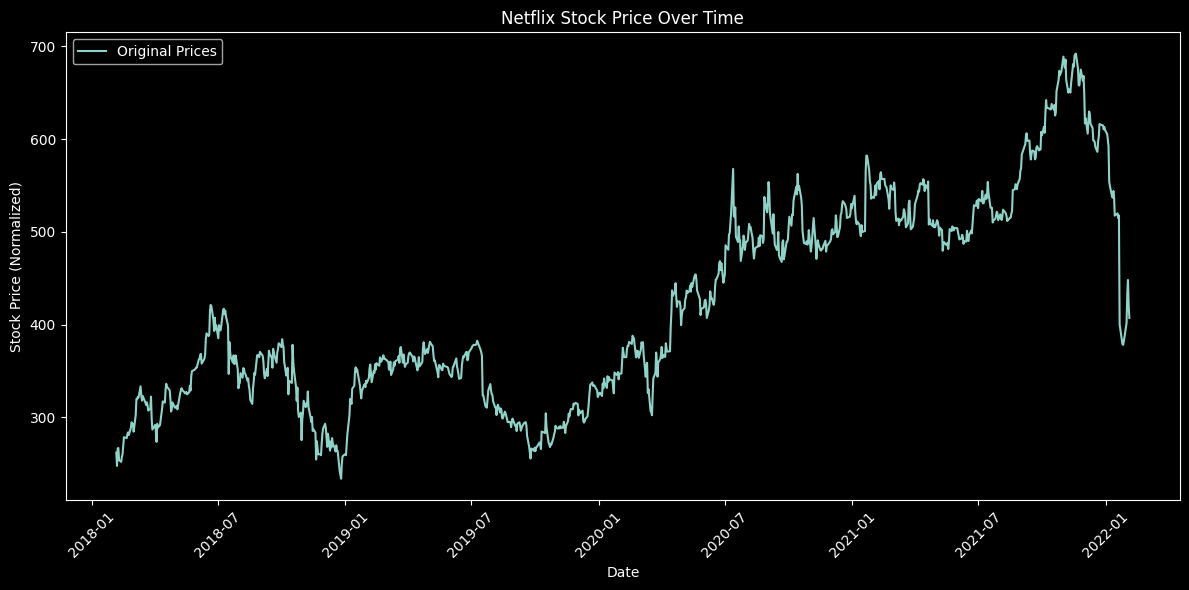

In [67]:
# Visualize Basic Data
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["Open"], label='Original Prices')
plt.title('Netflix Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Price (Normalized)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [68]:
# Prepare data for LSTM
sequence_length = 50
x, y = [], []
for i in range(len(data) - sequence_length):
    x.append(data[i:i+sequence_length])
    y.append(data[i+sequence_length])
x, y = np.array(x), np.array(y)

In [69]:
# Split into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(x))
x_train, x_test = x[:split_index], x[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [70]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [71]:
# Train the model
model.fit(x_train, y_train, epochs=40, batch_size=64, verbose=1)

Epoch 1/40
12/12 [==============================] - 6s 87ms/step - loss: 0.0347
Epoch 2/40
12/12 [==============================] - 1s 88ms/step - loss: 0.0093
Epoch 3/40
12/12 [==============================] - 2s 147ms/step - loss: 0.0048
Epoch 4/40
12/12 [==============================] - 1s 118ms/step - loss: 0.0034
Epoch 5/40
12/12 [==============================] - 1s 87ms/step - loss: 0.0031
Epoch 6/40
12/12 [==============================] - 1s 86ms/step - loss: 0.0029
Epoch 7/40
12/12 [==============================] - 1s 86ms/step - loss: 0.0029
Epoch 8/40
12/12 [==============================] - 1s 85ms/step - loss: 0.0028
Epoch 9/40
12/12 [==============================] - 1s 87ms/step - loss: 0.0027
Epoch 10/40
12/12 [==============================] - 1s 87ms/step - loss: 0.0027
Epoch 11/40
12/12 [==============================] - 1s 86ms/step - loss: 0.0027
Epoch 12/40
12/12 [==============================] - 1s 87ms/step - loss: 0.0026
Epoch 13/40
12/12 [================

In [72]:
# Evaluate the model
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_orig = scaler.inverse_transform(y_test)

6/6 [==============================] - 1s 20ms/step


In [88]:
# Calculate RMSE
rmse = np.sqrt(np.mean((predictions - y_test_orig)**2))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 30.10


In [89]:
# Generate predictions for the next month
predicted_prices_next_month = []

for _ in range(30):  # Predicting for the next 30 days
    prediction = model.predict(last_sequence.reshape(1, sequence_length, 1))
    predicted_prices_next_month.append(prediction[0, 0])
    last_sequence = np.append(last_sequence[1:], prediction[0, 0])

# Inverse transform the predicted prices
predicted_prices_next_month = np.array(predicted_prices_next_month).reshape(-1, 1)
predicted_prices_next_month = scaler.inverse_transform(predicted_prices_next_month)

1/1 [==============================] - 0s 31ms/step


In [93]:
from datetime import datetime, timedelta

# Generate dates for the next month (Assuming prediction starts from the last available date)
last_date = df["Date"].iloc[-1]
date_range = pd.date_range(start=last_date + timedelta(days=1), periods=30, freq='D')

# Create a DataFrame to hold the predicted prices and dates
predicted_df_next_month = pd.DataFrame({"Date": date_range, "Predicted_Price": predicted_prices_next_month[:, 0]})

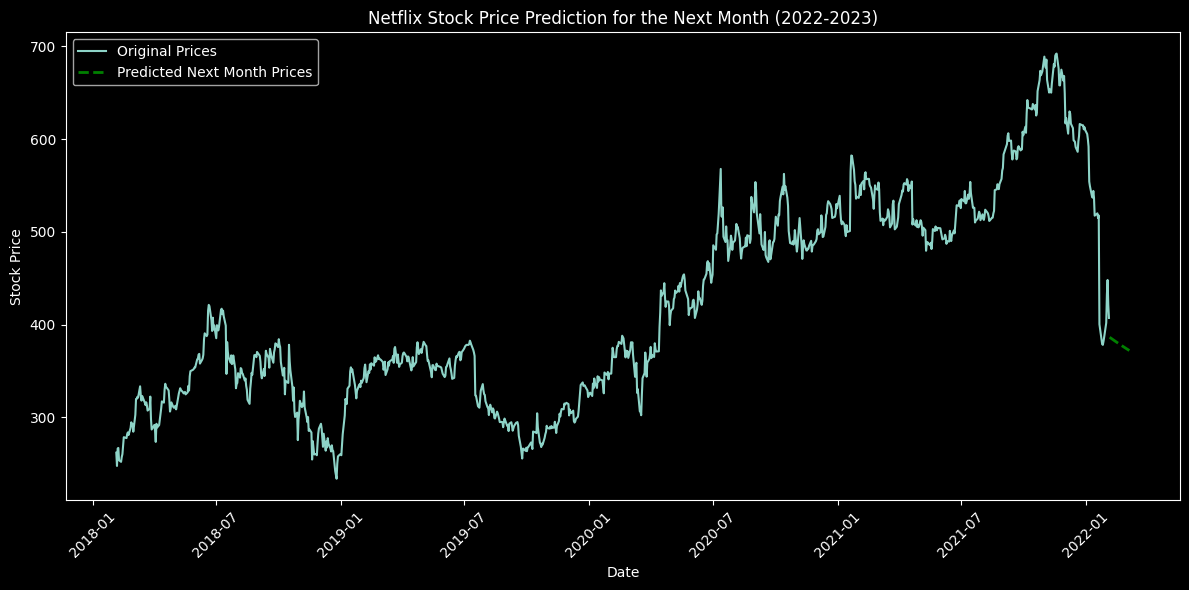

In [91]:
# Visualize Predicted Prices for the Next Month
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["Open"], label='Original Prices')
plt.plot(predicted_df_next_month["Date"], predicted_df_next_month["Predicted_Price"], label='Predicted Next Month Prices', color='green', linestyle='--', linewidth=2)
plt.title('Netflix Stock Price Prediction for the Next Month (2022-2023)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

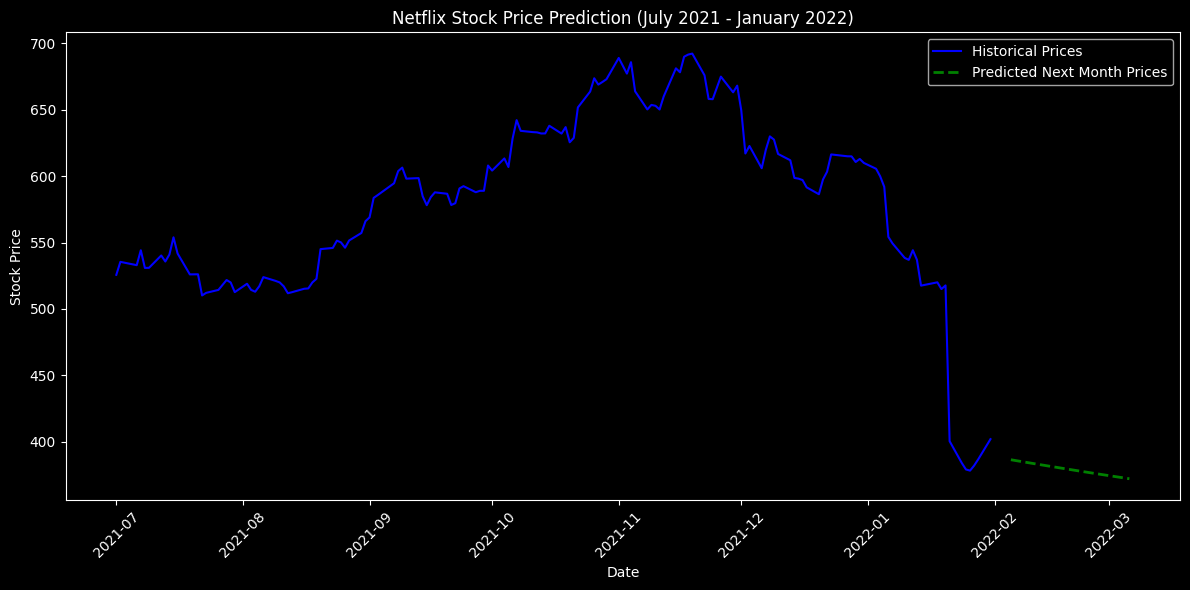

In [92]:
# Define the time range for visualization
start_date = datetime(2021, 7, 1)
end_date = datetime(2022, 1, 31)

# Filter data for the specified time range
filtered_data = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]

# Visualize Historical and Predicted Prices for the Specified Time Range
plt.figure(figsize=(12, 6))
plt.plot(filtered_data["Date"], filtered_data["Open"], label='Historical Prices', color='blue')
plt.plot(predicted_df_next_month["Date"], predicted_df_next_month["Predicted_Price"], label='Predicted Next Month Prices', color='green', linestyle='--', linewidth=2)
plt.title('Netflix Stock Price Prediction (July 2021 - January 2022)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
